### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from INO import Integral_NO
from utils import Green_func, plot_pred_v_truth
from ipywidgets import interact, FloatSlider

## Signal Example

### Data Load and Prep

In [25]:
x = np.genfromtxt('signal_data/signals_x_low.csv', delimiter=',', skip_header=1)
train_x = np.genfromtxt('signal_data/signals_low_train_x.csv', delimiter=',', skip_header=1)[:, np.newaxis, :]
train_y = np.genfromtxt('signal_data/signals_low_train_y.csv', delimiter=',', skip_header=1)[:, np.newaxis, :]
test_x = np.genfromtxt('signal_data/signals_low_test_x.csv', delimiter=',', skip_header=1)[:, np.newaxis, :]
test_y = np.genfromtxt('signal_data/signals_low_test_y.csv', delimiter=',', skip_header=1)[:, np.newaxis, :]

print("x shape:", x.shape)
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)

# Convert to tensors
train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)

test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

# ===========================
# Normalize train_x and test_x
# ===========================
x_max = train_x_tensor.max()

train_x_norm = train_x_tensor / x_max
test_x_norm = test_x_tensor / x_max  # use train stats

# ===========================
# Normalize train_y and test_y
# ===========================
y_max = train_y_tensor.max()

train_y_norm = train_y_tensor / y_max
test_y_norm = test_y_tensor / y_max  # use train stats


train_dataset = torch.utils.data.TensorDataset(train_x_norm, train_y_norm)
test_dataset = torch.utils.data.TensorDataset(test_x_norm, test_y_norm)

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

x shape: (49,)
train_x shape: (1500, 1, 49)
train_y shape: (1500, 1, 49)
test_x shape: (500, 1, 49)
test_y shape: (500, 1, 49)


### Training Loop

In [26]:
Integral_NO_model = Integral_NO(width=128, depth=5)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(Integral_NO_model.parameters(), lr=1e-4)

loss_history = []
val_loss_history = []

for epoch in range(200):
    Integral_NO_model.train()
    epoch_loss = 0

    for i, data in enumerate(training_loader):
        inputs, labels = data

        optimizer.zero_grad()

        # Forward pass
        outputs = Integral_NO_model(inputs, torch.Tensor(x.reshape(-1,1)))

        # Compute training loss
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        
        epoch_loss += loss.item()

    loss_history.append(loss.item())
    # ---- Validation evaluation ----
    Integral_NO_model.eval()
    val_loss = 0

    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_outputs = Integral_NO_model(val_inputs, torch.Tensor(x.reshape(-1,1)))
            val_loss += loss_fn(val_outputs, val_labels).item()

    val_loss /= len(validation_loader)  # Average validation loss per batch
    val_loss_history.append(val_loss)

    # ---- Print progress ----
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/len(training_loader):.6f}, Validation Loss: {val_loss:.6f}")


Epoch 1, Training Loss: 0.013905, Validation Loss: 0.013240
Epoch 2, Training Loss: 0.011816, Validation Loss: 0.010690
Epoch 3, Training Loss: 0.008944, Validation Loss: 0.007525


KeyboardInterrupt: 

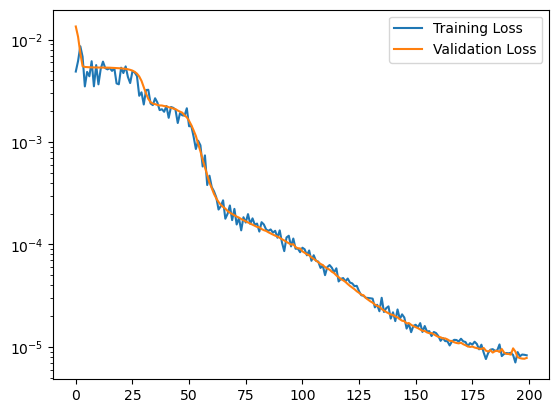

In [ ]:
plt.plot(loss_history, label = 'Training Loss')
plt.plot(val_loss_history, label = 'Validation Loss')
plt.yscale('log')
plt.legend()

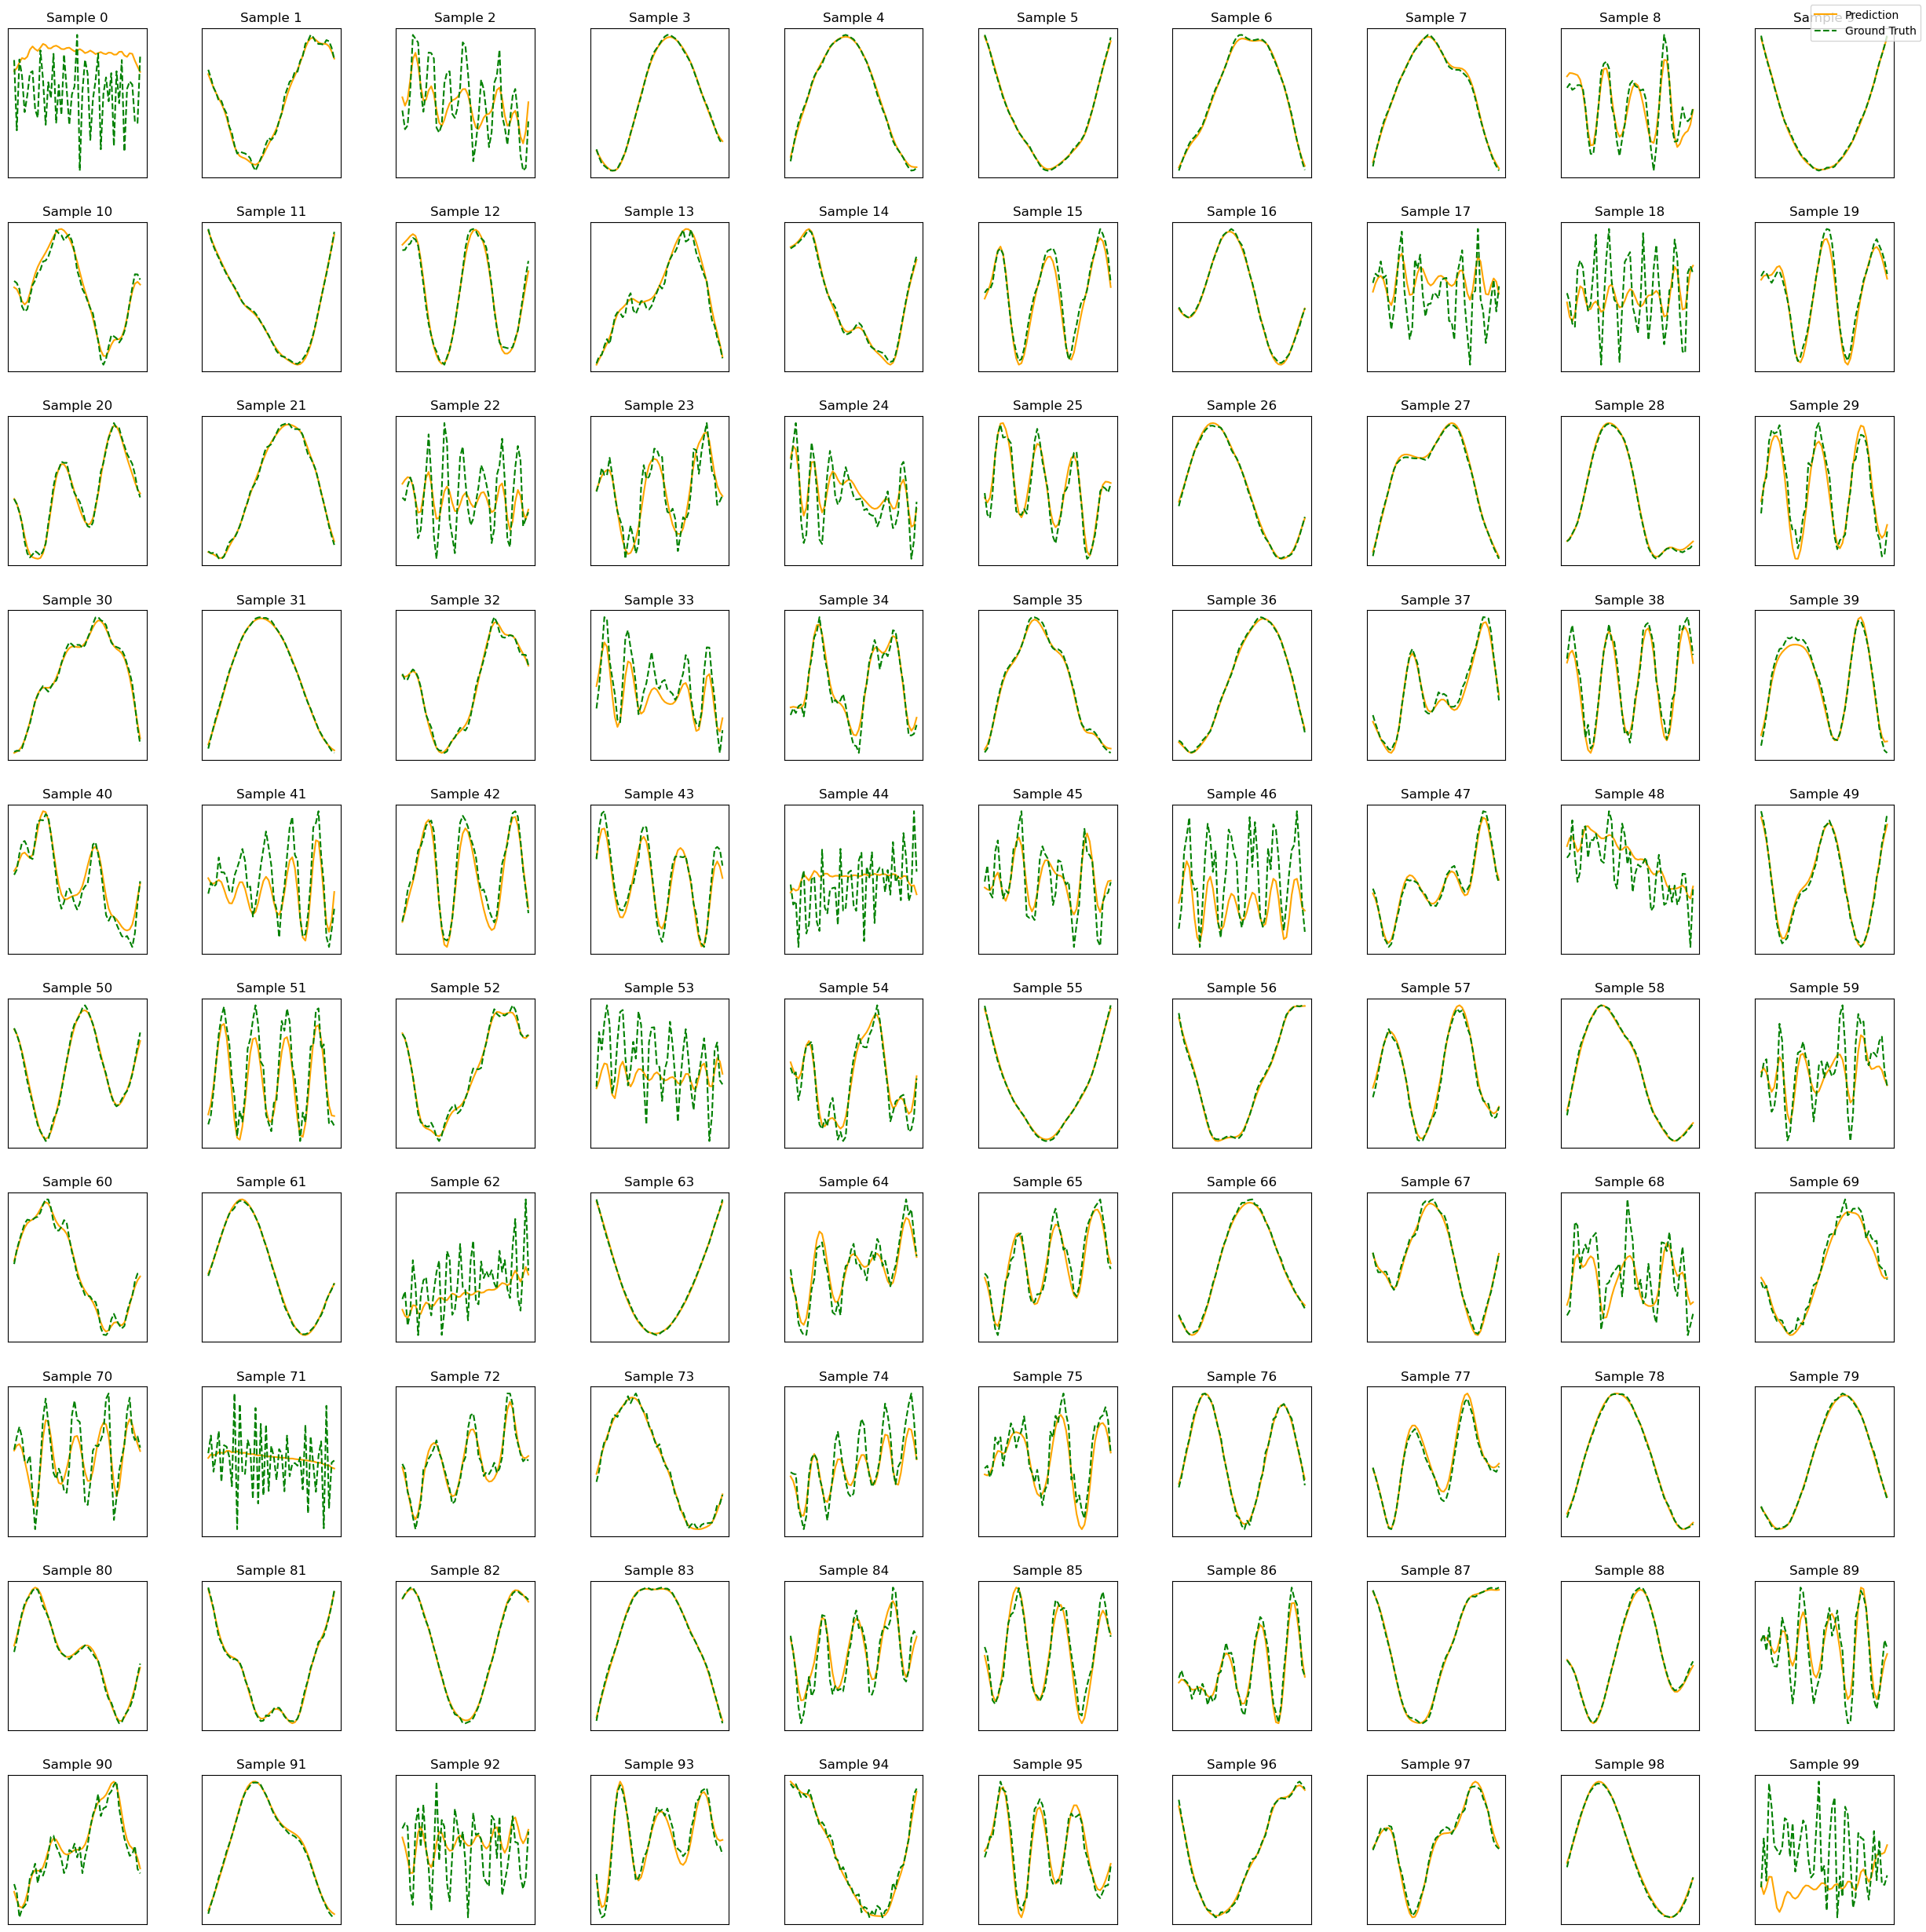

In [ ]:
# Get predictions
pred = Integral_NO_model(test_x_norm, torch.Tensor(x.reshape(-1,1))).detach().numpy()

plot_pred_v_truth(x, pred, test_y_norm)


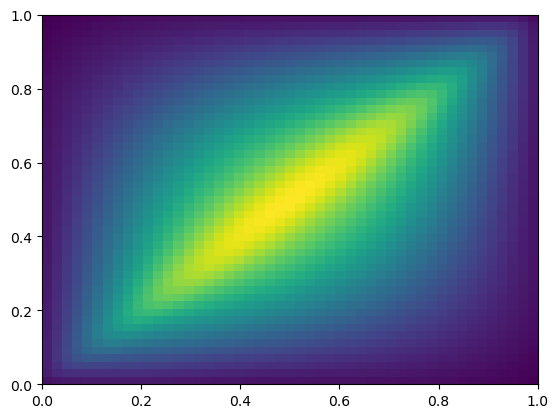

In [ ]:
X, Y = np.meshgrid(x,x)
X = torch.Tensor(X.flatten().reshape(-1,1))
Y = torch.Tensor(Y.flatten().reshape(-1,1))
res = Integral_NO_model.nn(X, Y).detach().numpy() 
plt.pcolormesh(X.numpy().reshape(49,49), Y.numpy().reshape(49,49), res.reshape(49,49), shading='auto', cmap='viridis')

In [ ]:
def integrate_green(signal, x, y, Green_func):
    """
    Computes the integral of G(x,y)*signal(y) dy for each x using np.trapz.
    """
    G_full = Green_func(x[:, None], y[None, :])  # Shape: (len(x), len(y))
    integrand = G_full * signal[None, :]         # Broadcast signal for all x
    final_signal = np.trapz(integrand, y, axis=1)
    return final_signal

def plot_impulse_response(y0, N):
    x = np.linspace(0, 1, int(N))
    y = np.linspace(0, 1, int(N))
    dx = x[1] - x[0]
    # ---- Real impulse response ----
    signal = np.zeros_like(y)
    idx = np.argmin(np.abs(y - y0))
    signal[idx] = 1 /dx

    final_signal = integrate_green(signal, x, y, Green_func)

    # ---- Model prediction ----
    impulse_signal = np.zeros((len(x),))
    idx_model = np.argmin(np.abs(x - y0))
    impulse_signal[idx_model] = 1

    # Reshape to (batch, channel, spatial)
    impulse_signal_torch = impulse_signal.reshape(1, 1, -1)

    with torch.no_grad():
        impulse_response = Integral_NO_model(torch.Tensor(impulse_signal_torch), torch.Tensor(x.reshape(-1,1))).detach().numpy()

    # ---- Plot both ----
    plt.figure(figsize=(8,4))
    plt.plot(x, final_signal, label='Real Impulse Response', linestyle='--')
    plt.plot(x, impulse_response[0][0], label='Model Prediction', alpha=0.7)
    plt.title(f'Impulse Response Comparison at y0={y0:.2f}')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive slider
interact(plot_impulse_response, y0=FloatSlider(min=0, max=1, step=0.01, value=0.3), N = FloatSlider(min=10, max=200, step=1, value=60))

interactive(children=(FloatSlider(value=0.3, description='y0', max=1.0, step=0.01), FloatSlider(value=60.0, de…

<function __main__.plot_impulse_response(y0, N)>

In [ ]:
highres_x = np.genfromtxt('signal_data/signals_x_high.csv', delimiter=',', skip_header=1)
highres_input = torch.Tensor(np.genfromtxt('signal_data/signals_high_train_x.csv', delimiter=',', skip_header=1)[:, np.newaxis, :])/x_max
highres_output = torch.Tensor(np.genfromtxt('signal_data/signals_high_train_y.csv', delimiter=',', skip_header=1)[:, np.newaxis, :])/y_max

print("highres_x shape:", highres_x.shape)
print("highres_input shape:", highres_input.shape)
print("highres_output shape:", highres_output.shape)

highres_x shape: (99,)
highres_input shape: torch.Size([1500, 1, 99])
highres_output shape: torch.Size([1500, 1, 99])


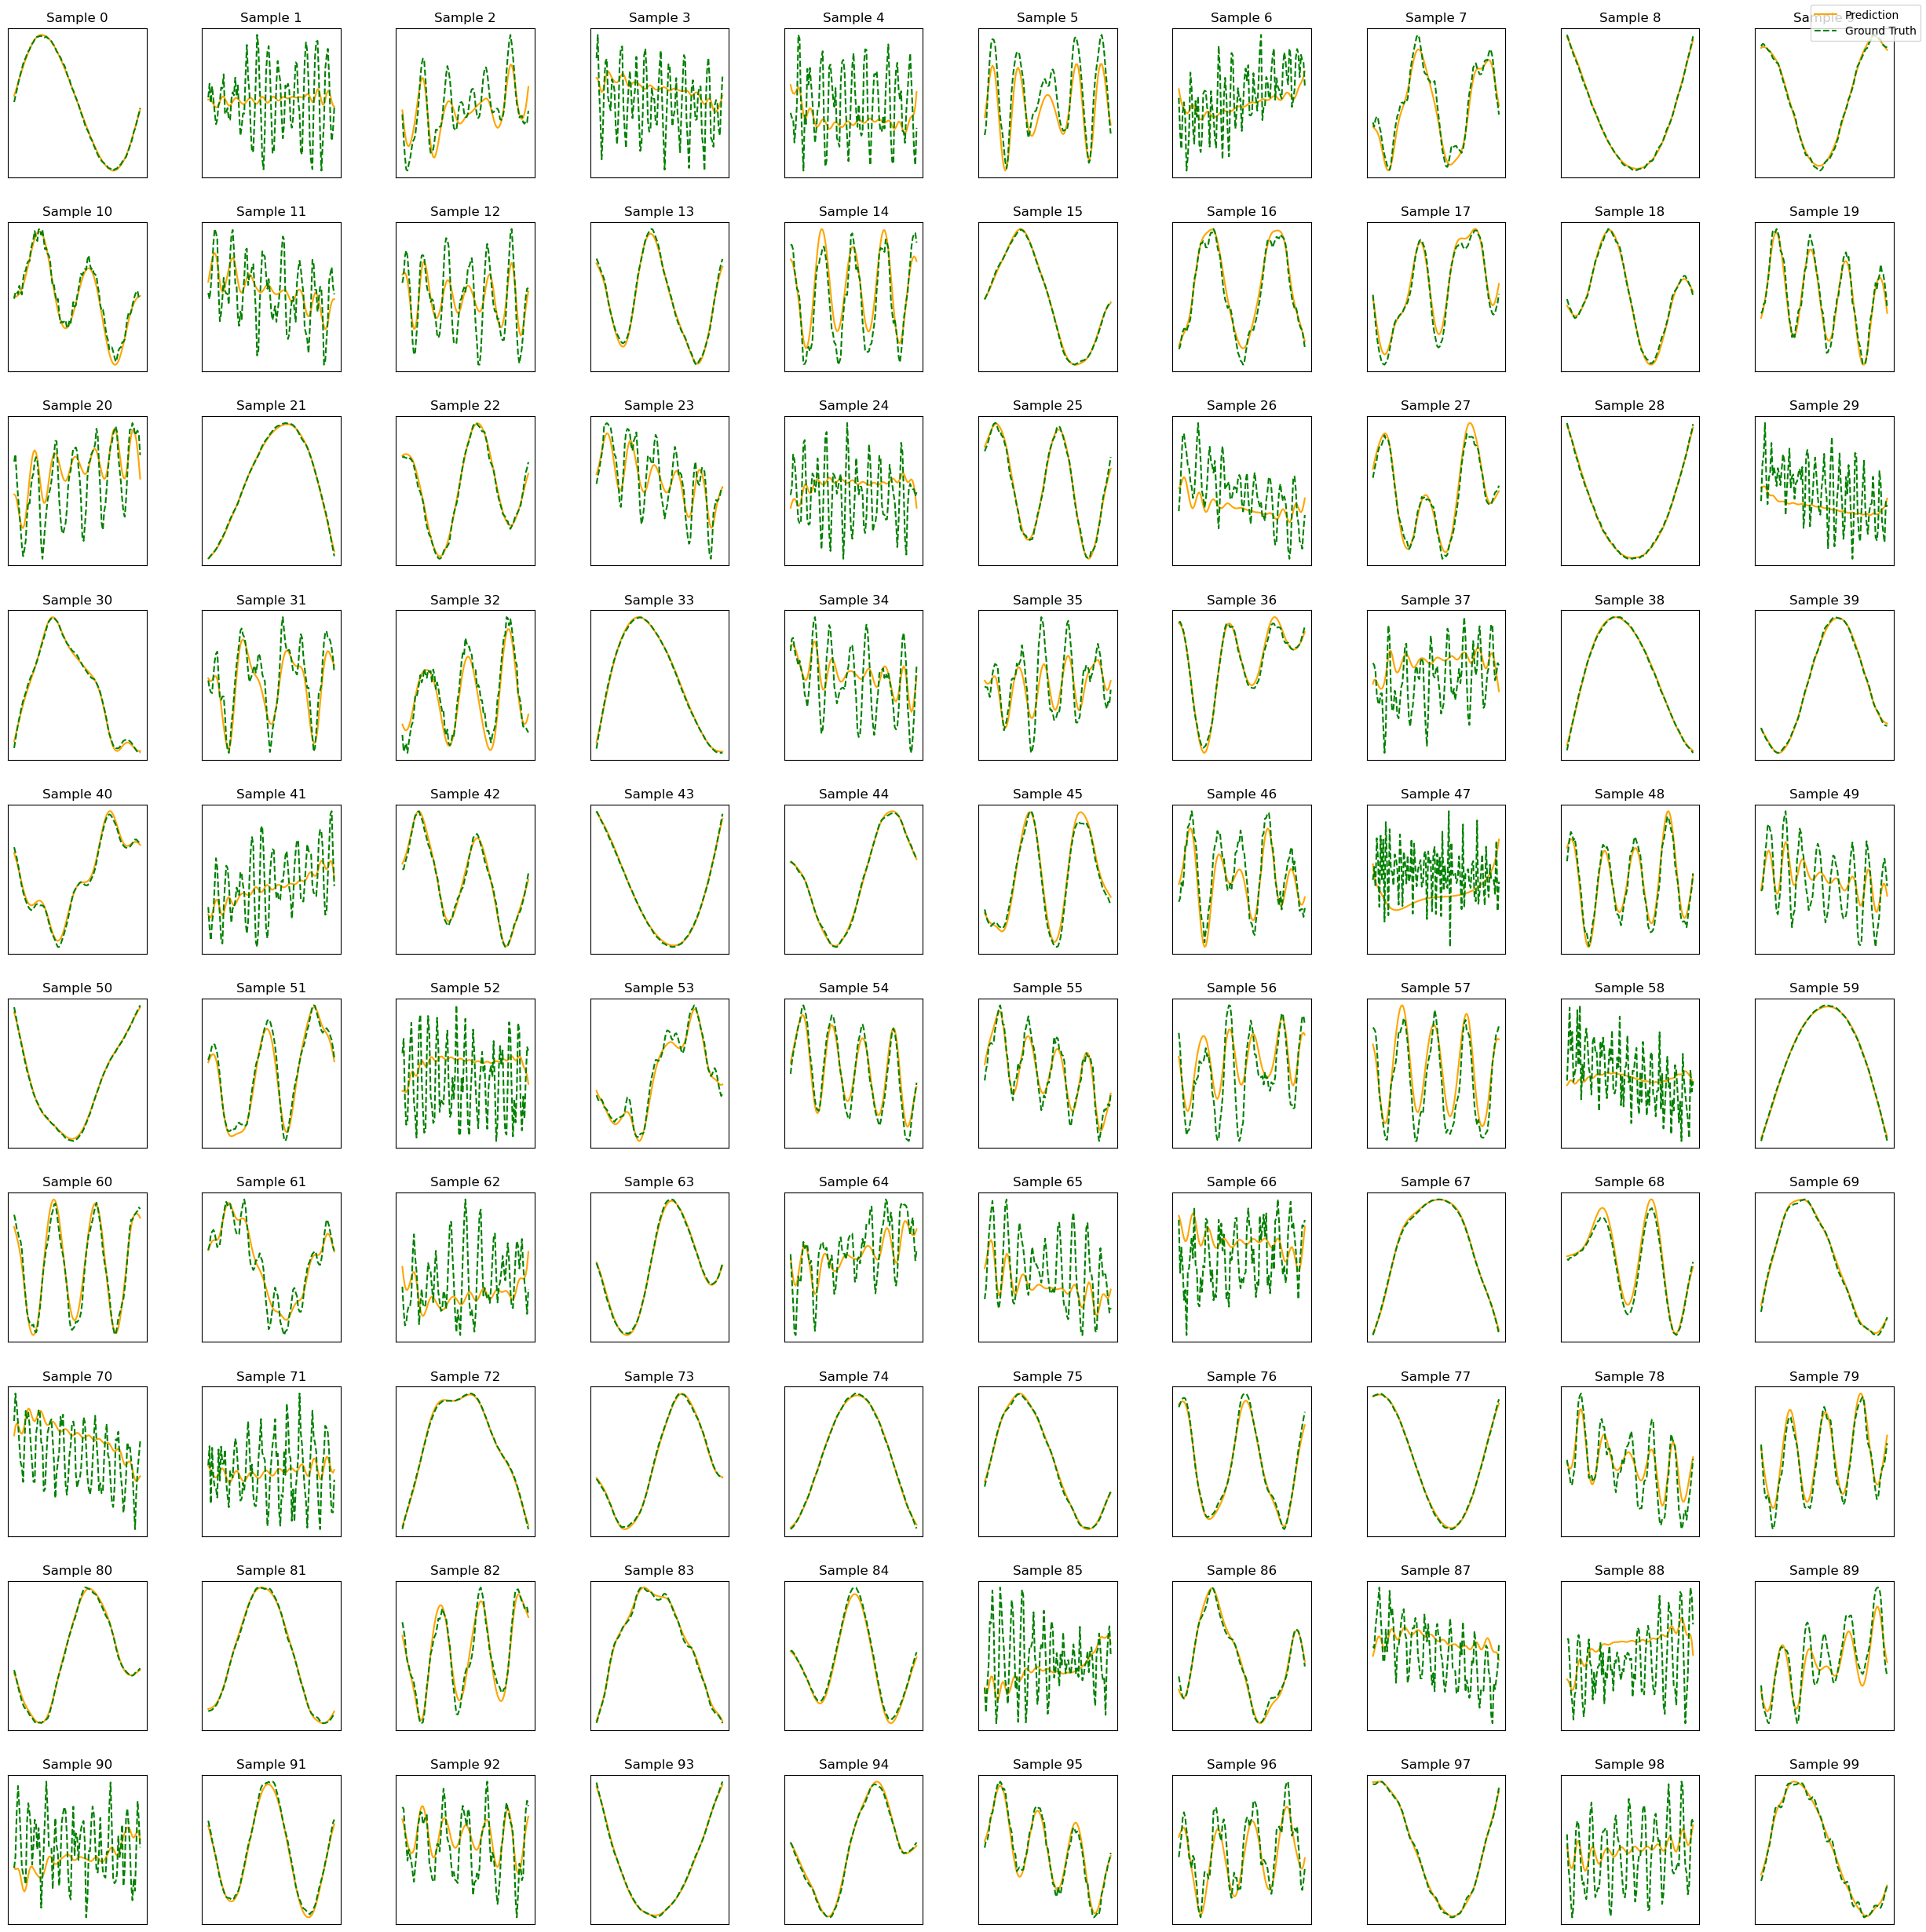

In [ ]:
# Get predictions
pred = Integral_NO_model(highres_input, torch.Tensor(highres_x.reshape(-1,1))).detach().numpy()

plot_pred_v_truth(highres_x, pred, highres_output)

## Pulse Data Example

In [2]:
# time = np.genfromtxt('pulse_data/time.csv', delimiter=',')[0][:1250:4]
# train_x = torch.Tensor(np.genfromtxt('pulse_data/train_x.csv', delimiter=',')[:, np.newaxis, :1250:4])
# train_y = torch.Tensor(np.genfromtxt('pulse_data/train_y.csv', delimiter=',')[:, np.newaxis, :1250:4])

# print("time shape:", time.shape)
# print("input_signal shape:", input_signal.shape)
# print("output_signal shape:", output_signal.shape)

# train_x = input_signal[:4]
# train_y = output_signal[:4]
# test_x = input_signal[4:]
# test_y = output_signal[4:]

# print("train_x shape:", train_x.shape)
# print("train_y shape:", train_y.shape)
# print("test_x shape:", test_x.shape)
# print("test_y shape:", test_y.shape)

time = np.genfromtxt('pulse_data/time.csv', delimiter=',')[0][::10]
train_x = torch.Tensor(np.genfromtxt('pulse_data/train_x.csv', delimiter=',', skip_header=1)[:, np.newaxis, ::10])
train_y = torch.Tensor(np.genfromtxt('pulse_data/train_y.csv', delimiter=',', skip_header=1)[:, np.newaxis, ::10])
test_x = torch.Tensor(np.genfromtxt('pulse_data/test_x.csv', delimiter=',', skip_header=1)[:, np.newaxis, ::10])
test_y = torch.Tensor(np.genfromtxt('pulse_data/test_y.csv', delimiter=',', skip_header=1)[:, np.newaxis, ::10])

print("time shape:", time.shape)
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)


time shape: (201,)
train_x shape: torch.Size([1000, 1, 201])
train_y shape: torch.Size([1000, 1, 201])
test_x shape: torch.Size([500, 1, 201])
test_y shape: torch.Size([500, 1, 201])


In [3]:
# Convert to tensors
train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)

test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

# ===========================
# Normalize train_x and test_x
# ===========================
x_max = train_x_tensor.max()

train_x_norm = train_x_tensor / x_max
test_x_norm = test_x_tensor / x_max  # use train stats

# ===========================
# Normalize train_y and test_y
# ===========================
y_max = train_y_tensor.max()

train_y_norm = train_y_tensor / y_max
test_y_norm = test_y_tensor / y_max  # use train stats


train_dataset = torch.utils.data.TensorDataset(train_x_norm, train_y_norm)
test_dataset = torch.utils.data.TensorDataset(test_x_norm, test_y_norm)

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

C:\Users\mathi\AppData\Local\Temp\ipykernel_14732\1448016.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
C:\Users\mathi\AppData\Local\Temp\ipykernel_14732\1448016.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
C:\Users\mathi\AppData\Local\Temp\ipykernel_14732\1448016.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
C:\Users\mathi\AppData\Local\Temp\ip

In [11]:
Integral_NO_model = Integral_NO(width=128, depth=3, activation = torch.tanh)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(Integral_NO_model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

loss_history = []
val_loss_history = []

for epoch in range(100):
    Integral_NO_model.train()
    epoch_loss = 0

    for i, data in enumerate(training_loader):
        inputs, labels = data

        optimizer.zero_grad()

        # Forward pass
        outputs = Integral_NO_model(inputs, torch.Tensor(time.reshape(-1,1)))

        # Compute training loss
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        
        epoch_loss += loss.item()

    #scheduler.step()
    loss_history.append(loss.item())
    # ---- Validation evaluation ----
    Integral_NO_model.eval()
    val_loss = 0

    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_outputs = Integral_NO_model(val_inputs, torch.Tensor(time.reshape(-1,1)))
            val_loss += loss_fn(val_outputs, val_labels).item()

    val_loss /= len(validation_loader)  # Average validation loss per batch
    val_loss_history.append(val_loss)

    # ---- Print progress ----
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/len(training_loader):.6f}, Validation Loss: {val_loss:.6f}")


Epoch 1, Training Loss: 193.461173, Validation Loss: 134.786024
Epoch 2, Training Loss: 48.337880, Validation Loss: 11.697952
Epoch 3, Training Loss: 9.751858, Validation Loss: 1.410202
Epoch 4, Training Loss: 3.395125, Validation Loss: 0.525129
Epoch 5, Training Loss: 1.195581, Validation Loss: 0.498138
Epoch 6, Training Loss: 0.507761, Validation Loss: 0.359129
Epoch 7, Training Loss: 0.250046, Validation Loss: 0.234907
Epoch 8, Training Loss: 0.144141, Validation Loss: 0.120335
Epoch 9, Training Loss: 0.097370, Validation Loss: 0.079261
Epoch 10, Training Loss: 0.080094, Validation Loss: 0.077788
Epoch 11, Training Loss: 0.075406, Validation Loss: 0.075970
Epoch 12, Training Loss: 0.071381, Validation Loss: 0.070588
Epoch 13, Training Loss: 0.068375, Validation Loss: 0.067582
Epoch 14, Training Loss: 0.066200, Validation Loss: 0.066205
Epoch 15, Training Loss: 0.064848, Validation Loss: 0.063977
Epoch 16, Training Loss: 0.062957, Validation Loss: 0.062412
Epoch 17, Training Loss: 0.

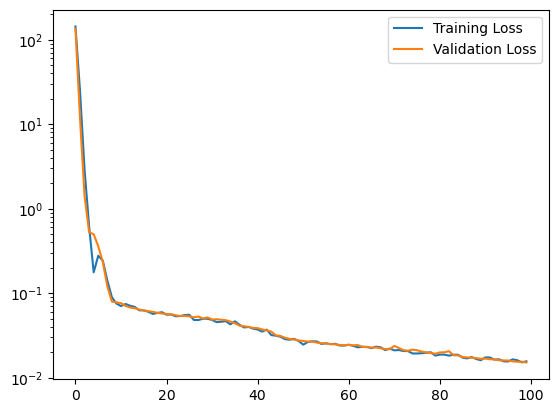

In [12]:
plt.plot(loss_history, label = 'Training Loss')
plt.plot(val_loss_history, label = 'Validation Loss')
plt.yscale('log')
plt.legend()

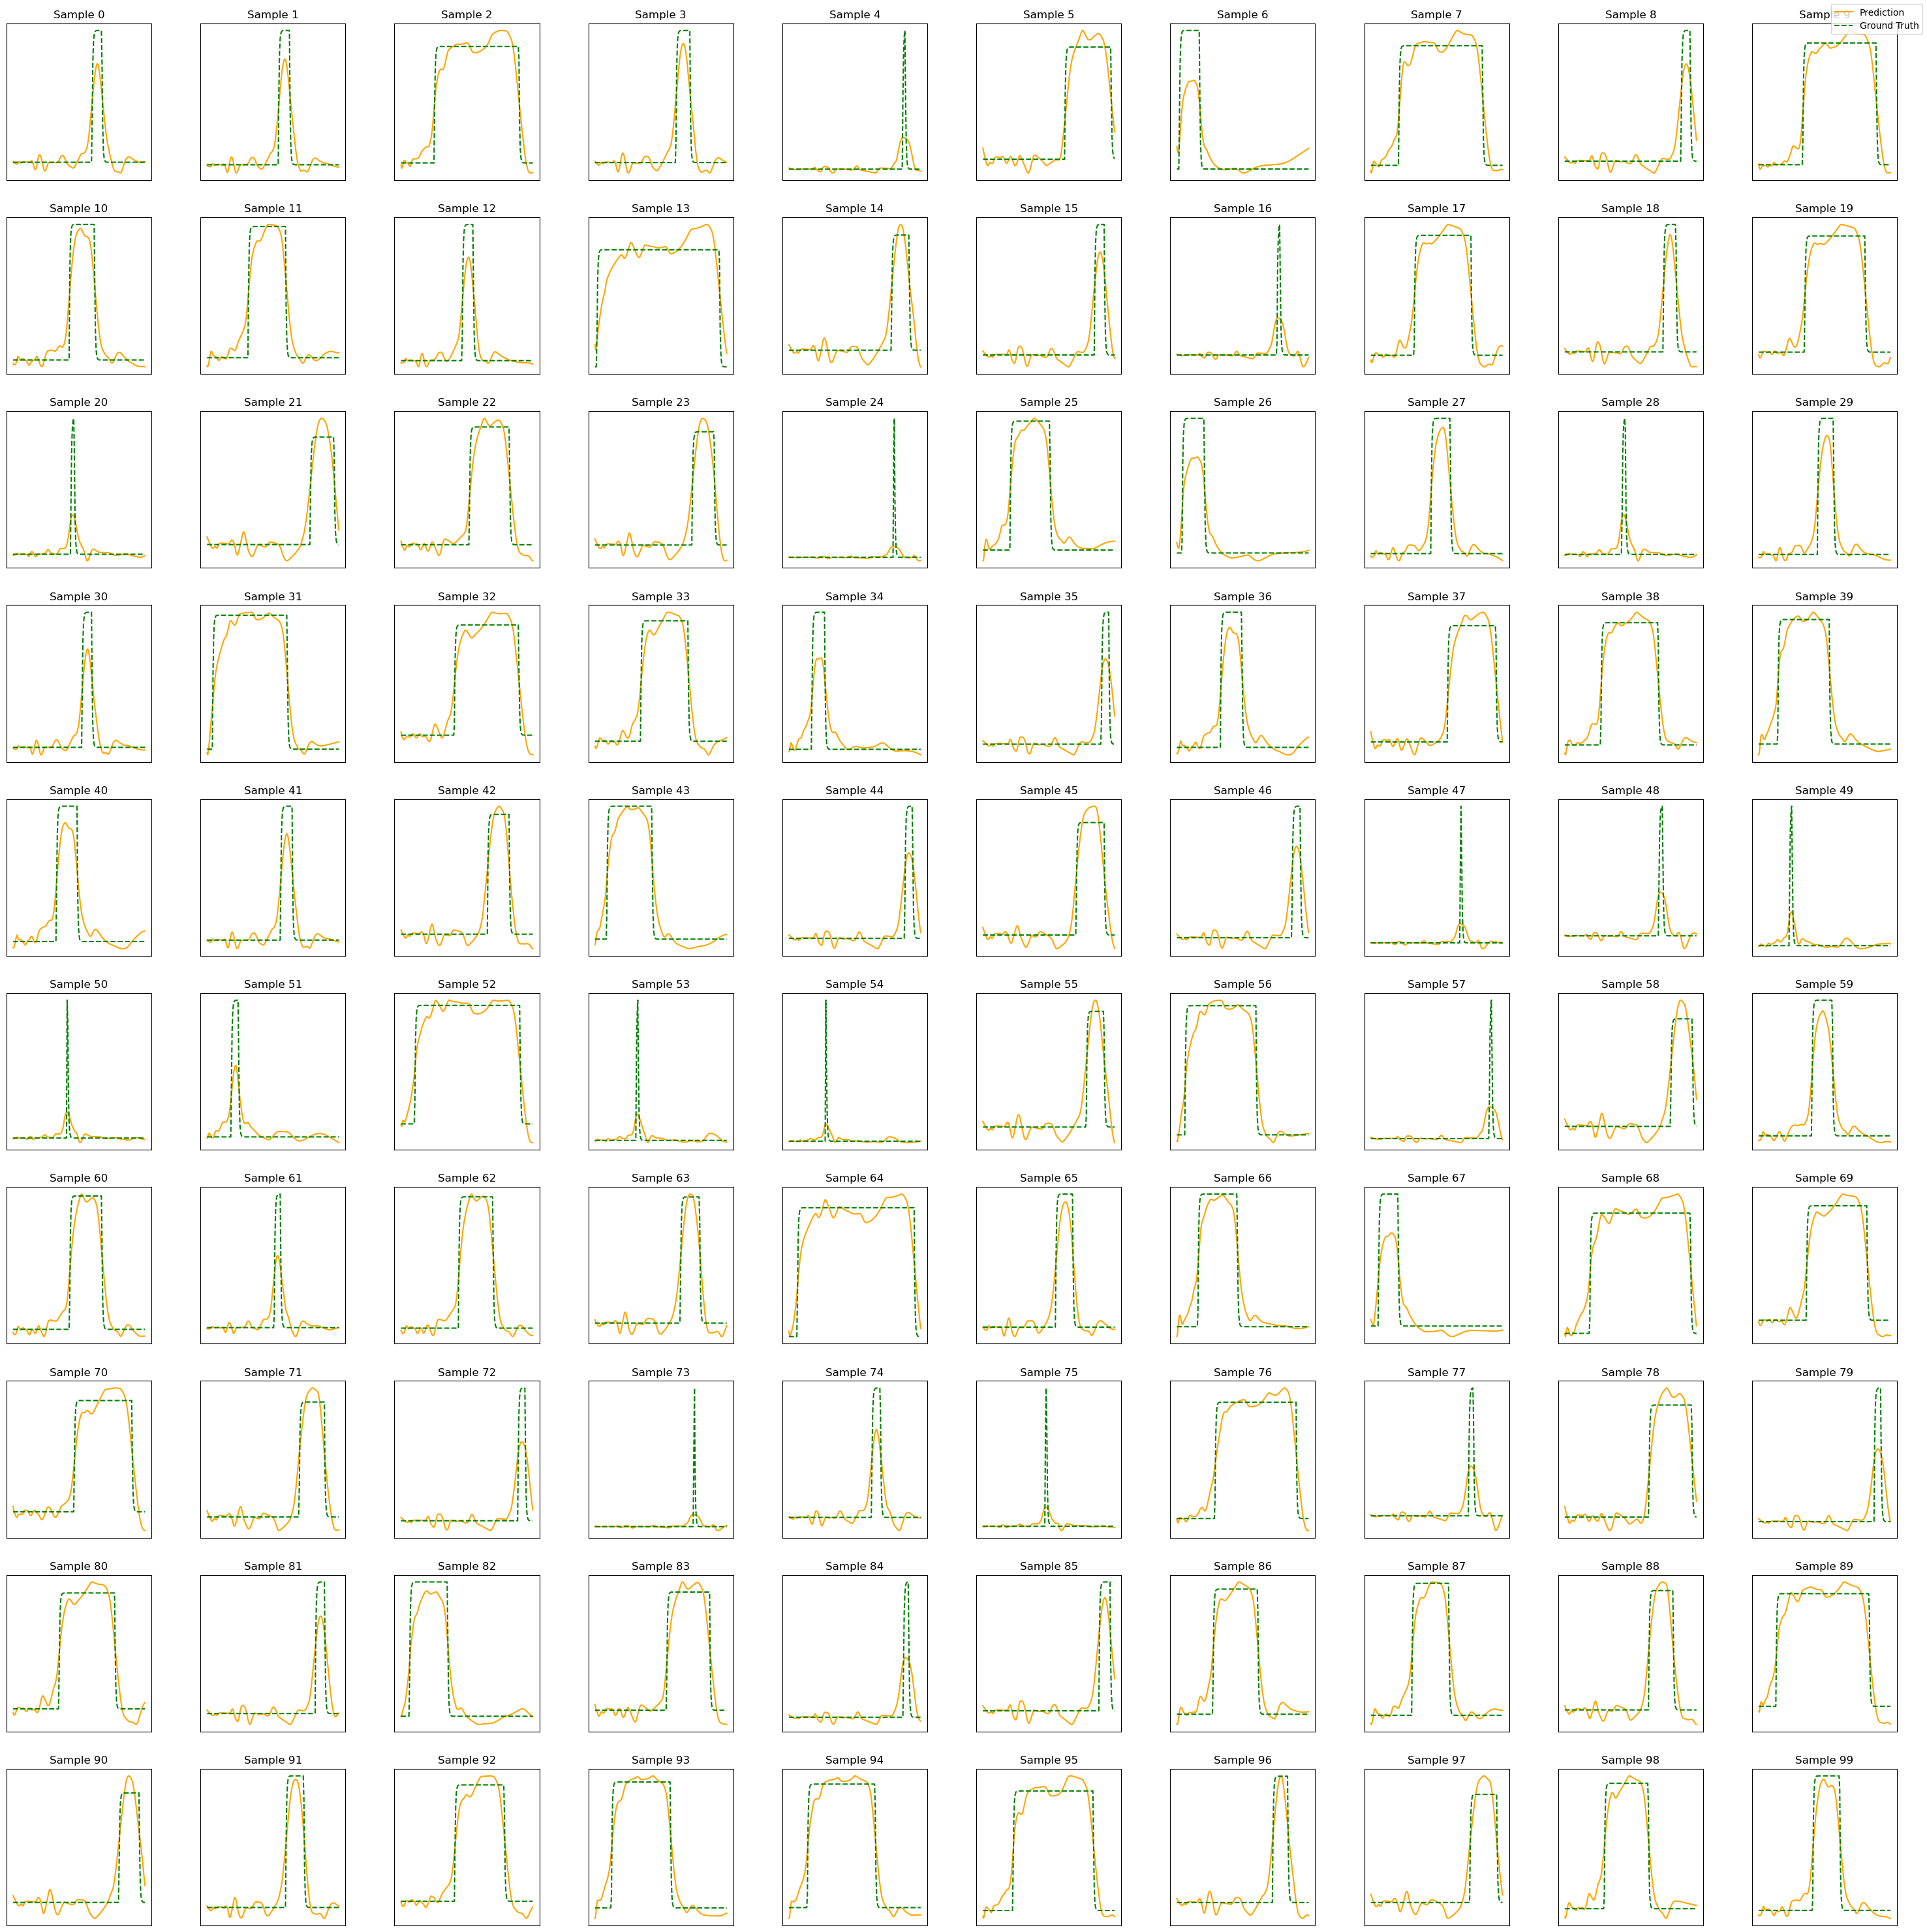

In [13]:
pred = Integral_NO_model(train_x_norm, torch.Tensor(time.reshape(-1,1))).detach().numpy()

plot_pred_v_truth(time, pred, train_y_norm)

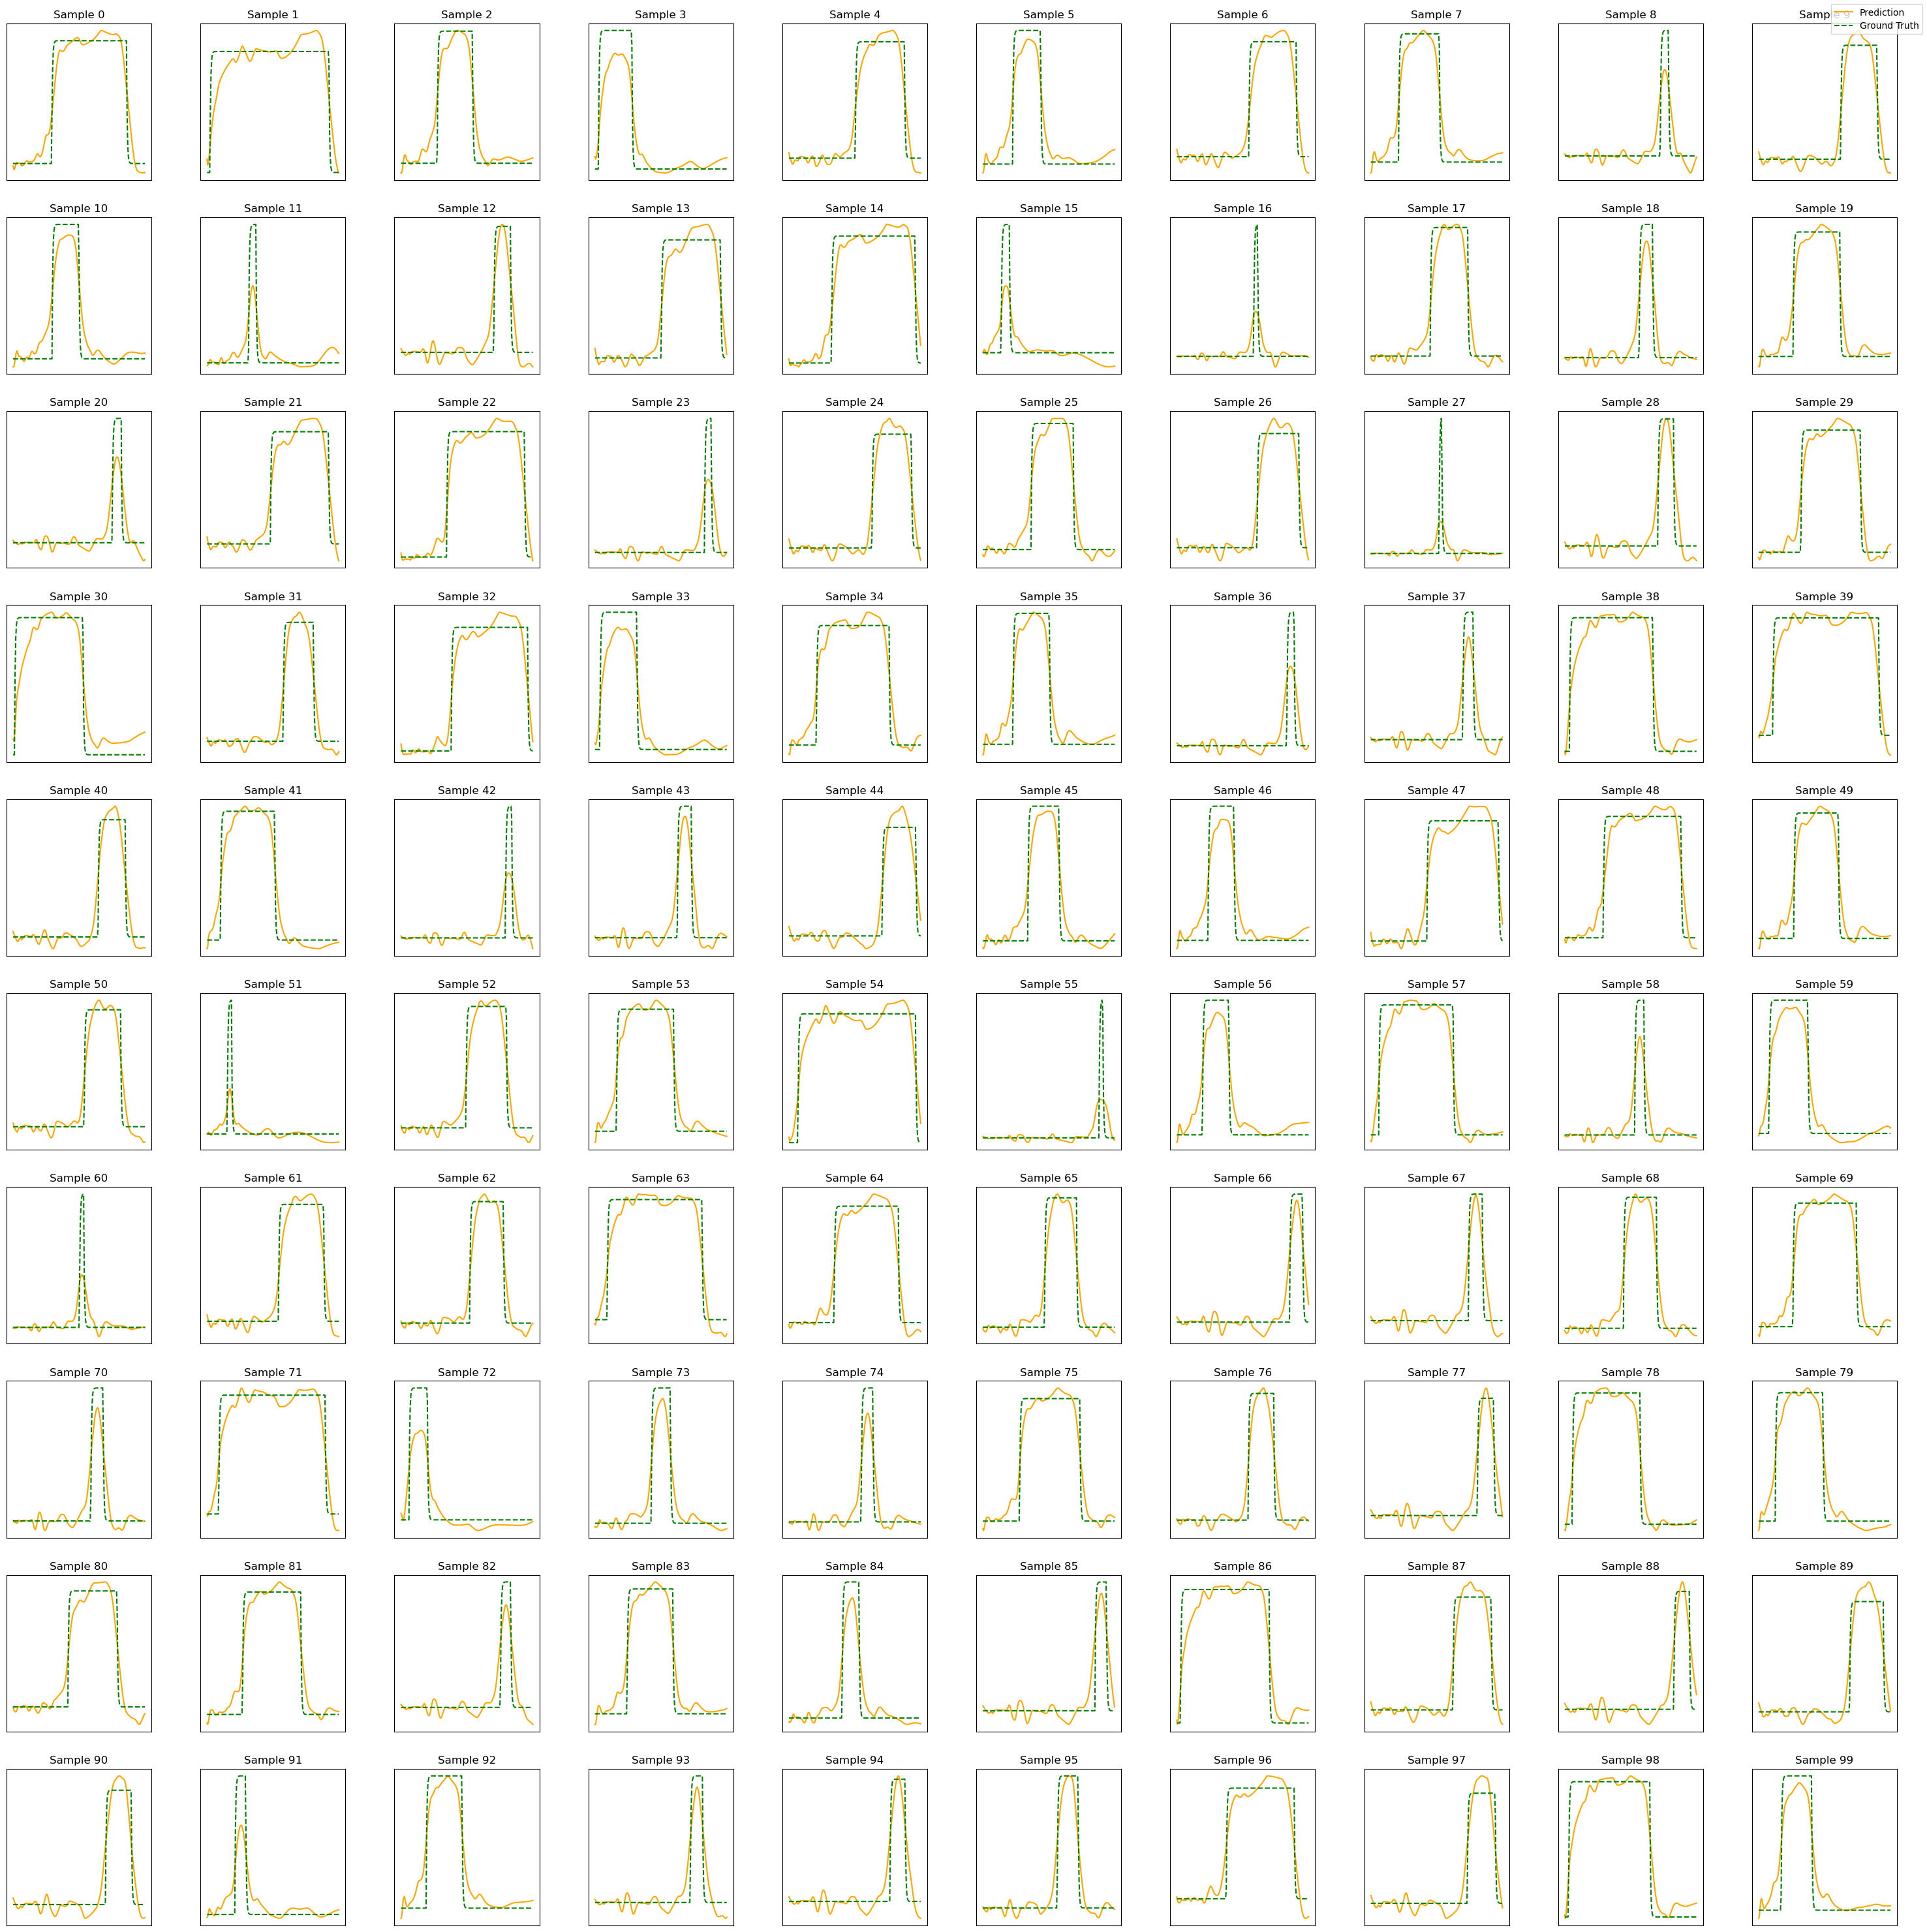

In [14]:
pred = Integral_NO_model(test_x_norm, torch.Tensor(time.reshape(-1,1))).detach().numpy()

plot_pred_v_truth(time, pred, test_y_norm)

## Friction Example

In [7]:
feature = np.genfromtxt('friction_data/features_SlipLaw_v2.csv', delimiter=',')[:, np.newaxis,:]
target = np.genfromtxt('friction_data/targets_SlipLaw_v2.csv', delimiter=',')[:, np.newaxis,:]
t = np.linspace(0,10,feature.shape[2])

print("t shape:", t.shape)
print("feature shape:", feature.shape)
print("target shape:", target.shape)


train_x = feature[:750,:,:]
train_y = target[:750,:,:]
test_x = feature[750:,:,:]
test_y = target[750:,:,:]

print("train_x shape:" , train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)


# ===========================
# Normalize train_x and test_x
# ===========================
x_max = train_x.max()

train_x_norm = np.log(np.log(1/train_x))
test_x_norm = np.log(np.log(1/test_x))

# ===========================
# Normalize train_y and test_y
# ===========================
y_max = train_y.max()

train_y_norm = train_y /y_max
test_y_norm = test_y / y_max  # use train stats

train_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_x_norm), torch.Tensor(train_y_norm))
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_x_norm), torch.Tensor(test_y_norm))

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

t shape: (150,)
feature shape: (1000, 1, 150)
target shape: (1000, 1, 150)
train_x shape: (750, 1, 150)
train_y shape: (750, 1, 150)
test_x shape: (250, 1, 150)
test_y shape: (250, 1, 150)


In [8]:
Integral_NO_model = Integral_NO(width=64, depth=5, activation = torch.tanh)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(Integral_NO_model.parameters(), lr=1e-2)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

loss_history = []
val_loss_history = []

for epoch in range(15):
    Integral_NO_model.train()
    epoch_loss = 0

    for i, data in enumerate(training_loader):
        inputs, labels = data

        optimizer.zero_grad()

        # Forward pass
        outputs = Integral_NO_model(inputs, torch.Tensor(t.reshape(-1,1)))

        # Compute training loss
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        
        epoch_loss += loss.item()

    #scheduler.step()
    loss_history.append(loss.item())
    # ---- Validation evaluation ----
    Integral_NO_model.eval()
    val_loss = 0

    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_outputs = Integral_NO_model(val_inputs, torch.Tensor(t.reshape(-1,1)))
            val_loss += loss_fn(val_outputs, val_labels).item()

    val_loss /= len(validation_loader)  # Average validation loss per batch
    val_loss_history.append(val_loss)

    # ---- Print progress ----
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/len(training_loader):.6f}, Validation Loss: {val_loss:.6f}")

Epoch 1, Training Loss: 43.700036, Validation Loss: 9.500008
Epoch 2, Training Loss: 2.333607, Validation Loss: 0.611983
Epoch 3, Training Loss: 0.435982, Validation Loss: 0.387821
Epoch 4, Training Loss: 0.228744, Validation Loss: 0.161557
Epoch 5, Training Loss: 0.169390, Validation Loss: 0.165448
Epoch 6, Training Loss: 0.163115, Validation Loss: 0.156005
Epoch 7, Training Loss: 0.157268, Validation Loss: 0.153571
Epoch 8, Training Loss: 0.155635, Validation Loss: 0.152739
Epoch 9, Training Loss: 0.154489, Validation Loss: 0.151242
Epoch 10, Training Loss: 0.153079, Validation Loss: 0.150570
Epoch 11, Training Loss: 0.152386, Validation Loss: 0.149721
Epoch 12, Training Loss: 0.151503, Validation Loss: 0.150404
Epoch 13, Training Loss: 0.150833, Validation Loss: 0.148043
Epoch 14, Training Loss: 0.150196, Validation Loss: 0.147690
Epoch 15, Training Loss: 0.149880, Validation Loss: 0.147860


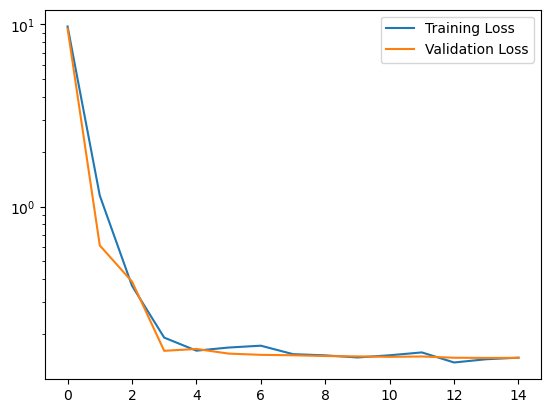

In [9]:
plt.plot(loss_history, label = 'Training Loss')
plt.plot(val_loss_history, label = 'Validation Loss')
plt.yscale('log')
plt.legend()

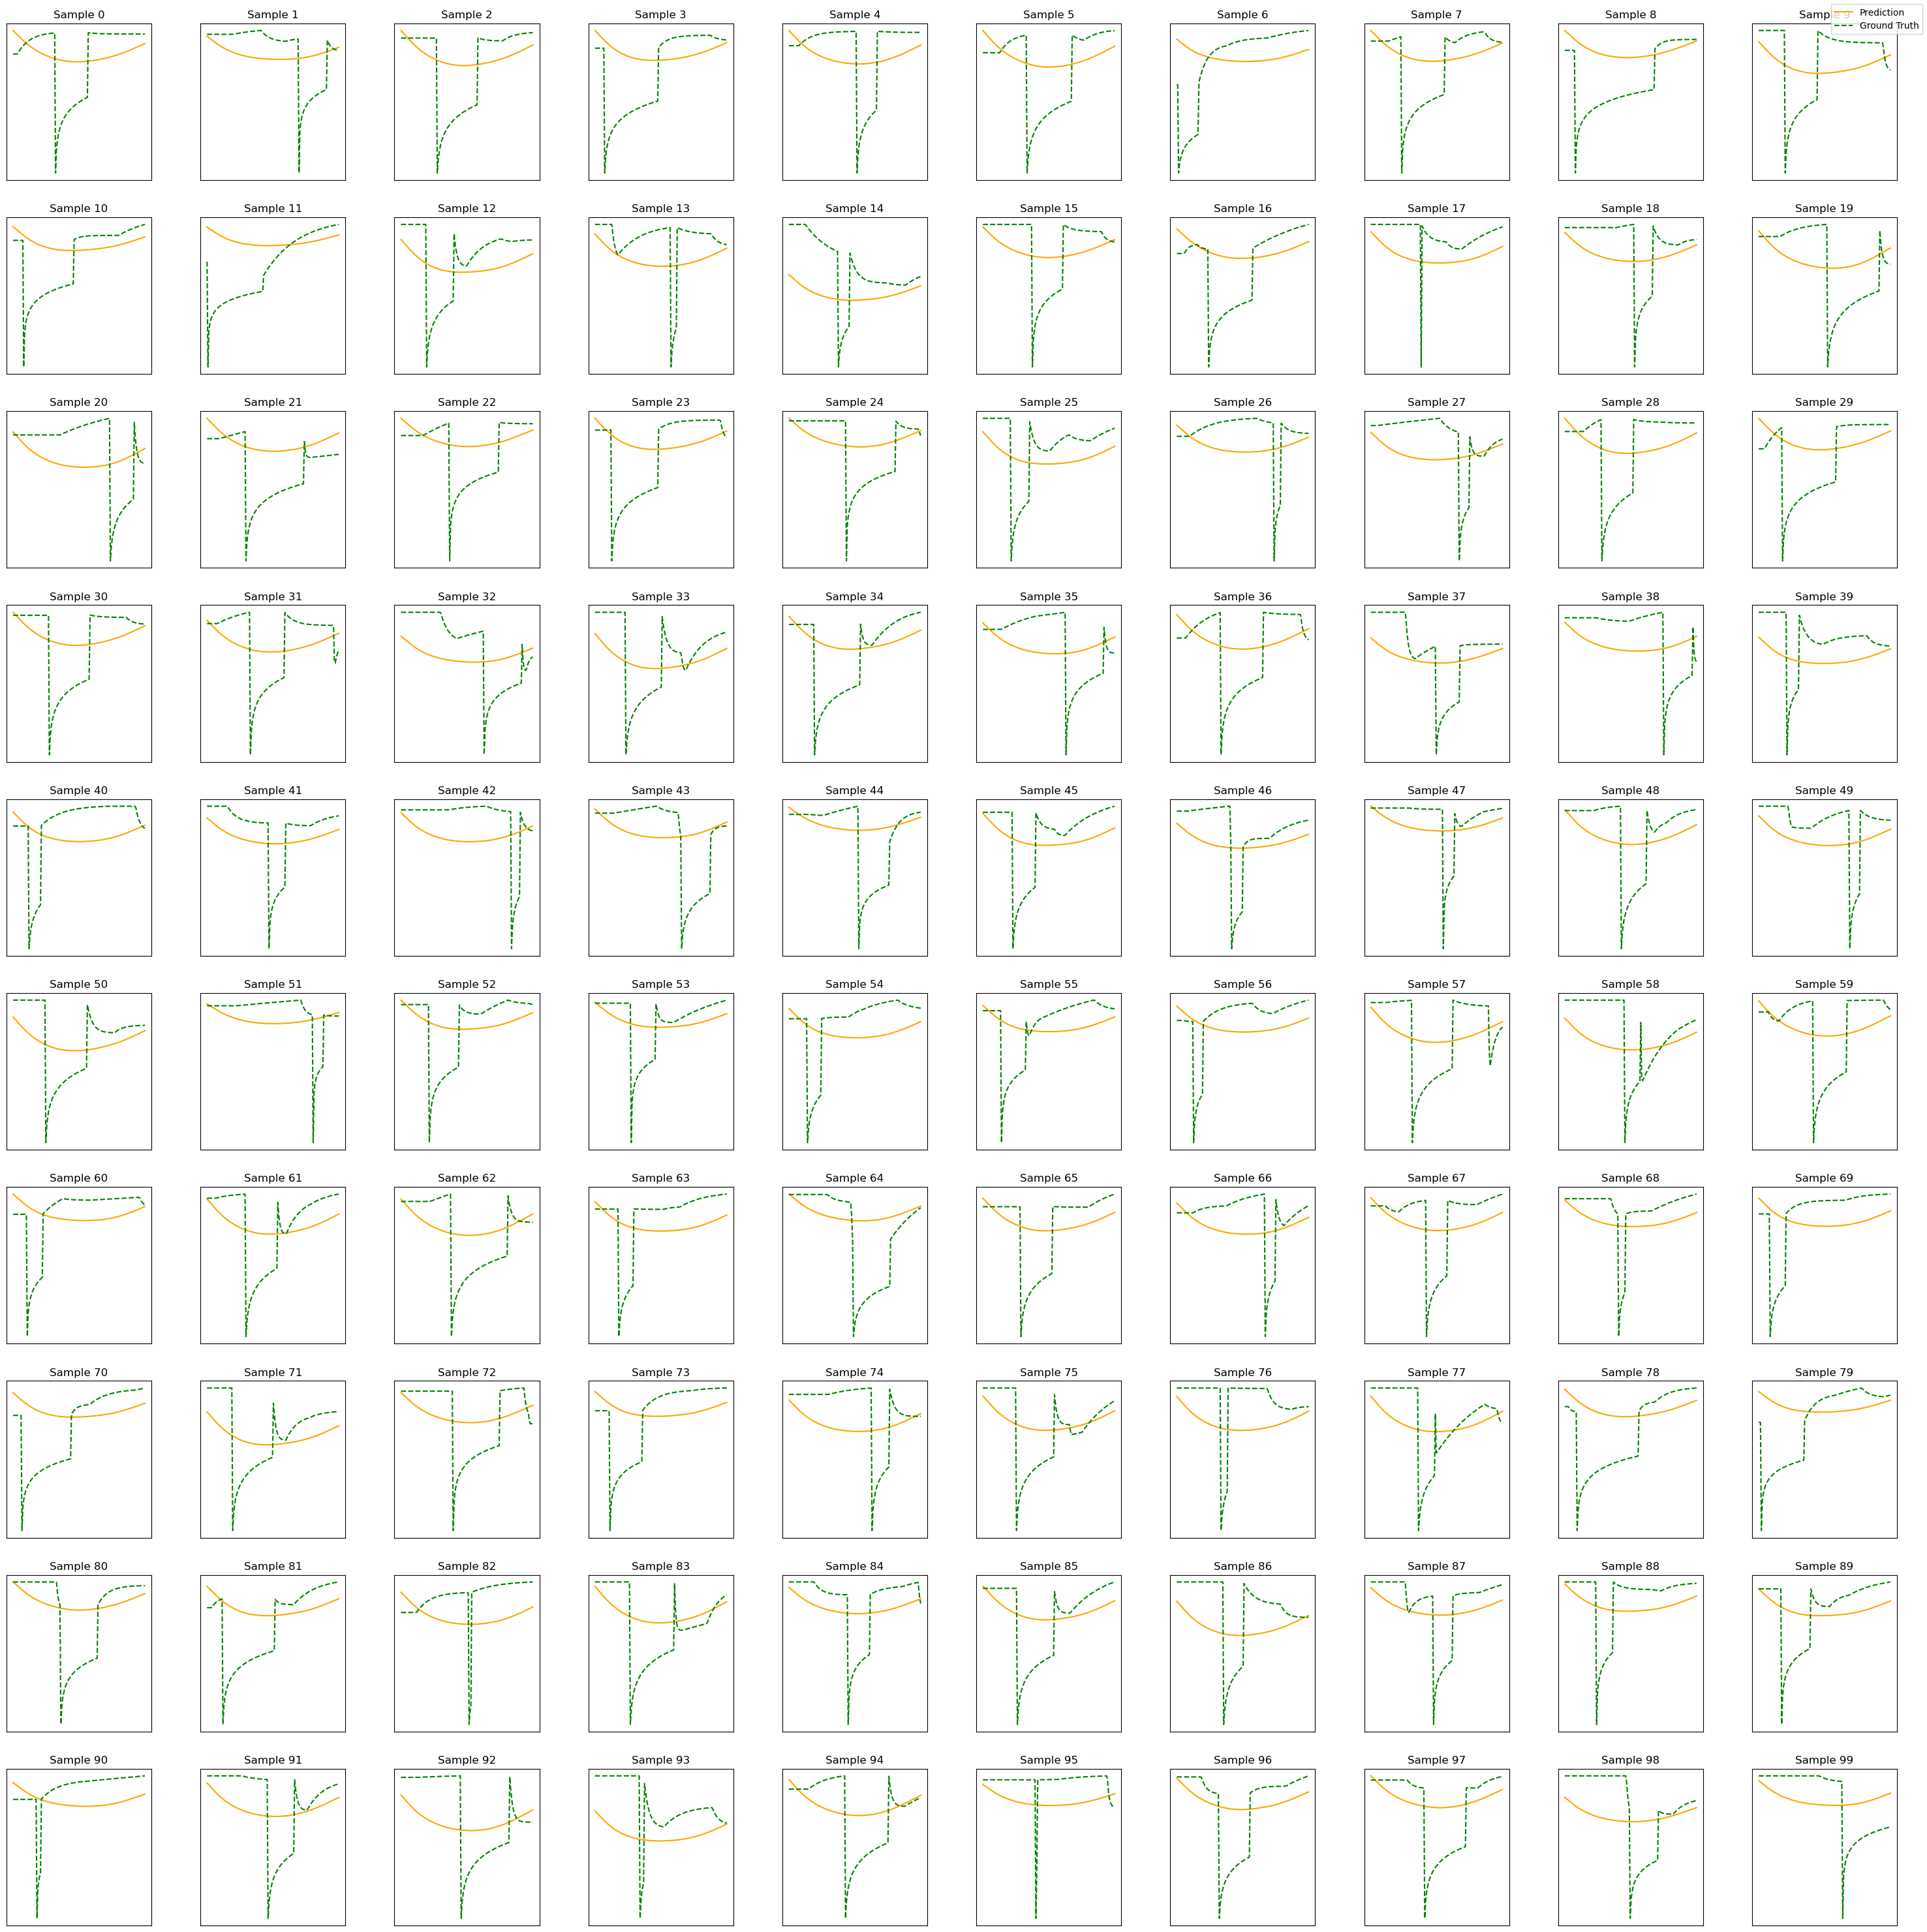

In [10]:
pred = Integral_NO_model(torch.Tensor(train_x_norm), torch.Tensor(t.reshape(-1,1))).detach().numpy()

plot_pred_v_truth(t, pred, train_y_norm)

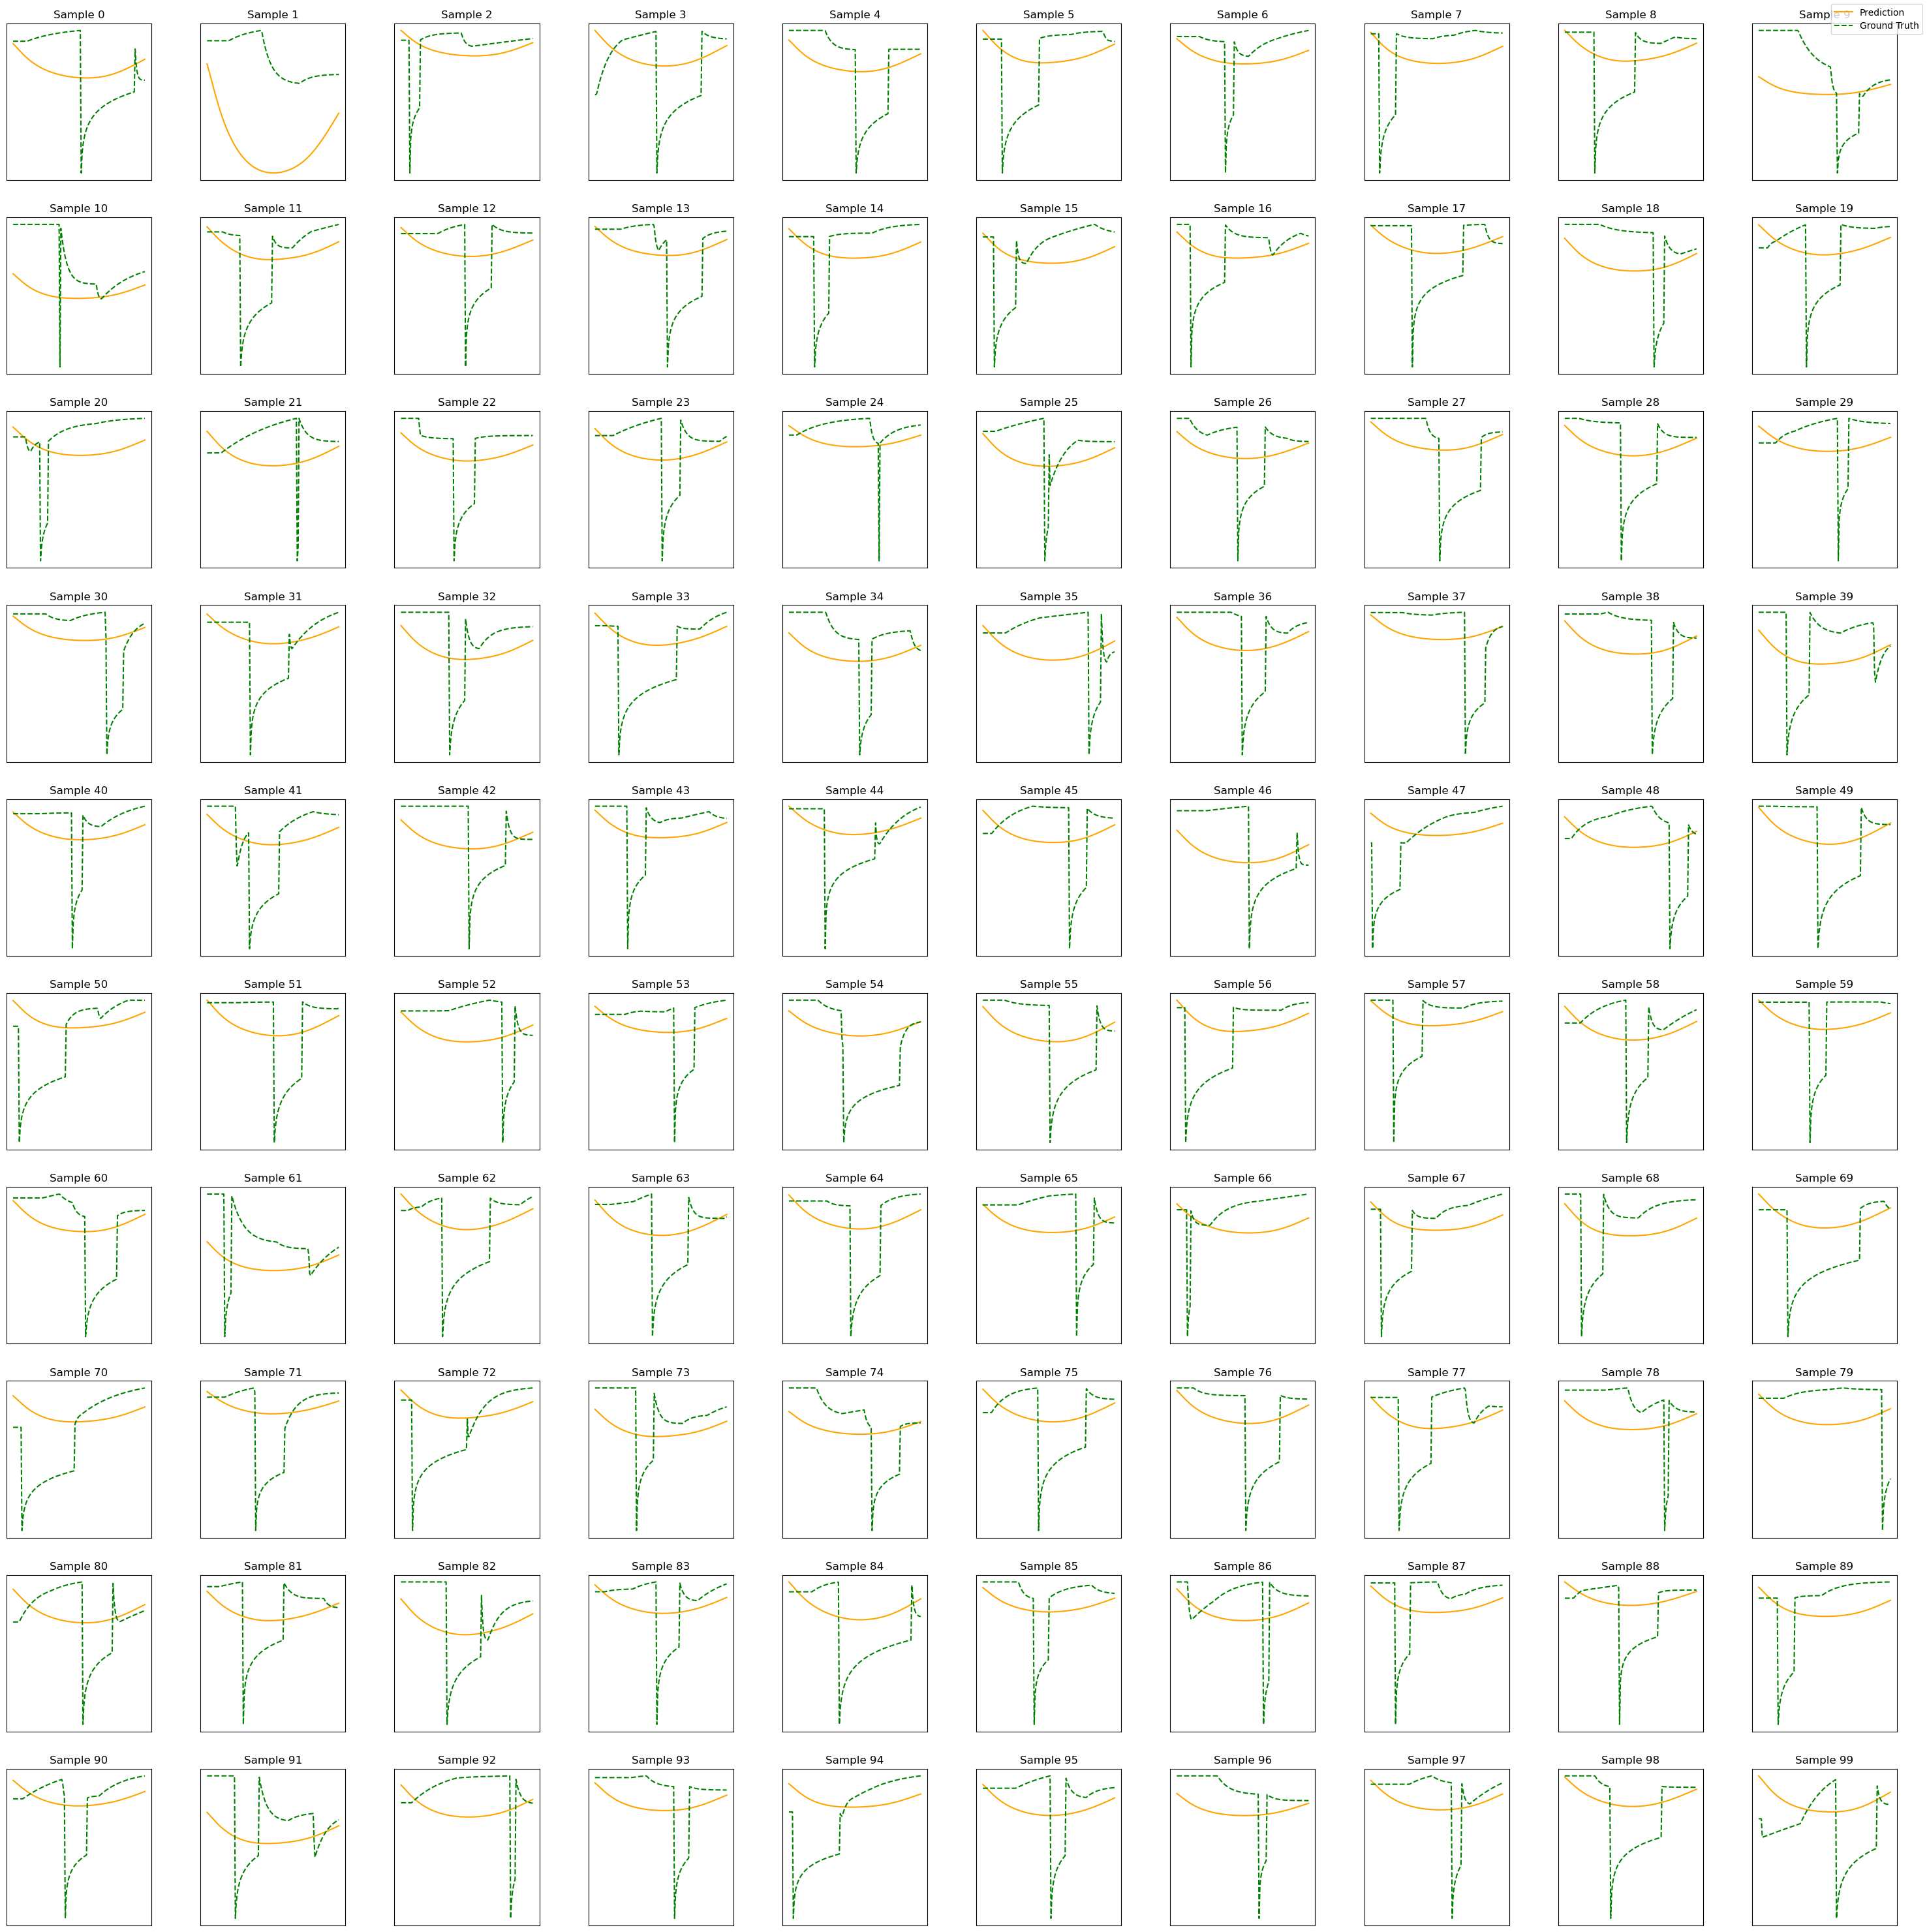

In [11]:
pred = Integral_NO_model(torch.Tensor(test_x_norm), torch.Tensor(t.reshape(-1,1))).detach().numpy()

plot_pred_v_truth(t, pred, test_y_norm)